In [77]:
kb = 1.380649 * 10**(-23) # J/K
hc = 6.62607015 * 10**(-34) # J·s
tem = 300

温度会导致导体内部的自由电子不断进行热运动，对于阻值为 R 的电阻，Johnson-Nyquist 噪声的电压谱密度（等于功率谱密度 * R）为：

$
S_{V2}(f,R,T) = 4k_BRT \frac{hf}{k_BT} \frac{1}{exp(hf/k_BT)-1}
$

在 300K 常温下，RF 频段（GHz），$hf<<k_BT$ （比值约在万分之一）。


In [78]:
import numpy as np

f=10*10**9 # 10 GHz
pt1 = hc*f/kb/tem
sv2_div_2kbrt = pt1/(np.exp(pt1)-1)

print(sv2_div_2kbrt) # 信号频率 10 GHz

0.9992003394204874


计算得到 $hf\frac{1}{exp(hf/k_BT)-1}\approx k_BT$，进一步得到 $S_{V2}\approx 4k_BRT$，也就是白噪声。并且，白噪声的频谱是均匀分布的，在所有频率上都有相同的能量密度。

从量子的角度解释，温度引起了光子数涨落，进而和量子比特耦合，其密度为 $n(T,f)=\frac{1}{exp(hf/k_BT)-1} (unit: HZ^{-1} s^{-1})$ 。

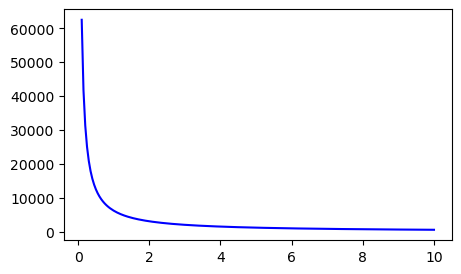

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def fun_pho_density(f):
    f0=f*10**9 # GHz
    return 1/(np.exp(hc*f0/kb/tem)-1)

fig=plt.figure(figsize=(5,3))
x=np.linspace(0.1,10,200)
ax=fig.add_subplot()
ax.plot(x,fun_pho_density(x),'b')
plt.show()

上图取 0-10 GHz 的范围，可以看到频率越高，热激发产生的光子数密度越低。但是同时光子频率越高，最终的噪声密度仍是一个与 f 无关的定值。\
现在考虑降低光子数密度，各线缆通道需要多少衰减：

- XY 通道信号频率在 4-6 GHz，降低到 $10^{-2}$ 以下。
- READOUT-IN 频率 6-8 GHz，降低到 $10^{-3}$ 以下。

Q1：既然热噪声分布在全频段，并且其强度仅和温度有关，和输入信号无关。那么这里为何仅针对 f 频率的热光子？是否热噪声仅仅对相应频率的信号影响较大？\
A1：在 REF.KONG.P57 找到了答案 “对于 qubit readout 线路来说，实际有影响的是频率𝑓𝑐附近的噪声成分”，这对于其他线路应该也是一样的。

In [80]:
import numpy as np

def fun_attenuator(f,pho):
    f0=f*10**9 # GHz
    rate=1/(np.exp(hc*f0/kb/tem)-1)/pho
    db=np.log10(rate)*10
    return db

print ("XY通道光子数压低到 0.01:", fun_attenuator(5,0.01))
print ("READOUT-IN光子数压低到 0.001:",fun_attenuator(7,0.001))

XY通道光子数压低到 0.01: 50.968048016530815
READOUT-IN光子数压低到 0.001: 59.506072787009785


Q2：这里的计算出现了异常，根据 REF.某计算环境支撑系统项目方案（ZB) -0908.docx 的结果：
- XY通道光子数压低到 0.01 ，需要 50 dB 的衰减。
- READOUT-IN光子数压低到 0.001 ， 需要 70 dB 。<font color="red">与计算的 60 dB 不符，见下图。该问题暂放。</font>

<img src="image/attenuator.png" width="40%">

In [81]:
import scipy as sp

print ("XY 光子数:", sp.integrate.quad(fun_pho_density, 4, 6)[0])
print ("READOUT-IN 光子数:", sp.integrate.quad(fun_pho_density, 6, 8)[0])

XY 光子数: 2533.5567409469786
READOUT-IN 光子数: 1797.2967183234166


积分两个通道的光子数，分别是 2533 和 1797

---
实际上，每层的热源都会产生热噪声。接下来考虑按上图的设计，XY 通道上每一层产生的热噪声经过后级逐级衰减之后，到达 base (MC) 层时的电压谱密度。
1. 首先，已知 PT2 和 MC 层各有一个 20 dB 的衰减器。
2. 接着需要计算各层间线缆的损耗，不同线缆单位长度的插损可以从 REF.某计算环境支撑系统项目方案（ZB) -0908.docx 中获得：
    |高密度半刚线插损约为15.6dB/m|
    |----|
    RT-PT1：15.6 dB/m×0.18m＝2.808dB
    PT1-PT2：15.6 dB/m×0.286m＝4.4616dB
    PT2-Still：15.6 dB/m×0.248m＝3.8688dB
    Still-CP：15.6 dB/m×0.166m＝2.5896dB

    |普通密度半刚线插损约为15dB/m|
    |----|
    RT-PT1：15 dB/m×0.25m＝3.75dB
    PT1-PT2：15dB/m×0.265m＝3.975dB
    PT2-Still：15dB/m×0.22m＝3.3dB
    Still-CP：15 dB/m×0.07m＝1.05dB

    CP-MC 使用的是 NbTi 线，极低温下基本没有损耗，\
    300mm 半柔线插损为1.44dB，\
    LPF 5850+插损为0.83dB，\
    LPF 500+插损为0.94dB。

全部衰减： 55.998000000000005


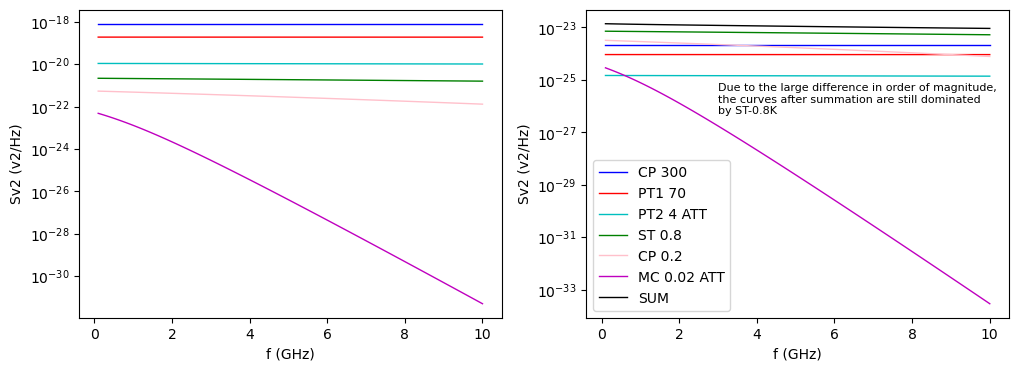

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# 线缆损耗归到上层
db_rt=2.808
db_pt1=4.4616
db_pt2=3.8688
att1=20
db_st=2.5896
db_cp=0
db_mc=1.44
att2=20
lpf=0.83
list_db=[db_rt,db_pt1,db_pt2+att1,db_st,db_cp,db_mc+att2+lpf]
list_tem=[300,70,4,0.8,0.2,0.02]

print ("全部衰减：", sum(db[0:6]))

def fun_sv2(f,ltem,lay):
    f0=f*10**9 # GHz
    rz=50 # 阻抗先取定值
    sv2=4*r*hc*f0/(np.exp(hc*f0/kb/ltem[lay])-1)
    return sv2

def fun_sv2_db(f,ltem,ldb,lay):
    f0=f*10**9 # GHz
    rz=50
    db=sum(ldb[lay:6])
    sv2=4*r*hc*f0/(np.exp(hc*f0/kb/ltem[lay])-1)*10**(-db/10)
    return sv2

fig=plt.figure(figsize=(12,4))
x=np.linspace(0.1,10,100)

ax1=fig.add_subplot(1,2,1)
ax1.set_yscale('log')
ax1.set_xlabel('f (GHz)')
ax1.set_ylabel('Sv2 (v2/Hz)')
ax1.plot(x,fun_sv2(x,list_tem,0),'blue',lw=1)
ax1.plot(x,fun_sv2(x,list_tem,1),'red',lw=1)
ax1.plot(x,fun_sv2(x,list_tem,2),'c',lw=1)
ax1.plot(x,fun_sv2(x,list_tem,3),'green',lw=1)
ax1.plot(x,fun_sv2(x,list_tem,4),'pink',lw=1)
ax1.plot(x,fun_sv2(x,list_tem,5),'m',lw=1)

ax2=fig.add_subplot(1,2,2)
ax2.set_yscale('log')
ax2.set_xlabel('f (GHz)')
ax2.set_ylabel('Sv2 (v2/Hz)')
ax2.plot(x,fun_sv2_db(x,list_tem,list_db,0),'blue',lw=1,label="CP 300")
ax2.plot(x,fun_sv2_db(x,list_tem,list_db,1),'red',lw=1,label="PT1 70")
ax2.plot(x,fun_sv2_db(x,list_tem,list_db,2),'c',lw=1,label="PT2 4 ATT")
ax2.plot(x,fun_sv2_db(x,list_tem,list_db,3),'green',lw=1,label="ST 0.8")
ax2.plot(x,fun_sv2_db(x,list_tem,list_db,4),'pink',lw=1,label="CP 0.2")
ax2.plot(x,fun_sv2_db(x,list_tem,list_db,5),'m',lw=1,label="MC 0.02 ATT")
ax2.text(3,5*10**(-27),'Due to the large difference in order of magnitude, \nthe curves after summation are still dominated \nby ST-0.8K',fontsize=8,ha='left')
ax2.plot(x,sum([fun_sv2_db(x,list_tem,list_db,i) for i in range(6)]),'k',lw=1,label="SUM")

ax2.legend()
plt.show()


可以看出
- 只有在 20 mK 层，谱密度对频率敏感，这时热光子能量 $hf$ 接近热力学标度 $k_BT$；
- 由于在 4-6 GHz 范围，20 mK 层与其他层存在数量级上的差异，求和后的谱密度曲线（black）仍以 0.8K 层（green）为主。

下面来考虑，将芯片接收的总噪声，等价到仅从 MC 层产生的噪声，从而得到 MC 层的等价温度。

In [83]:
import numpy as np
sv2=fun_sv2(5,0.8,3)
print (sv2)

f0=5*10**9
r=50
db0=db[5]
print (db0)
# sv2=4*r*hc*f0/(np.exp(hc*f0/kb/tem)-1)*10**(-db0/10)

tem_cross=hc*f0/kb/np.log(4*r*hc*f0*10**(-db0/10)/sv2+1)
print ("MC 和 ST 交叉点：", tem_cross)
print (fun_sv2(5,tem,5))


6.187033877958538e-24
22.27
MC 和 ST 交叉点： 0.48808247460197757
4.909766418214974e-21


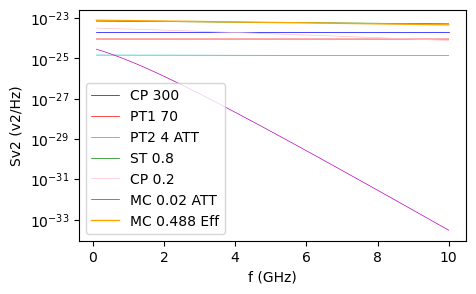

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(5,3))
x=np.linspace(0.1,10,100)

ax=fig.add_subplot()
ax.set_yscale('log')
ax.set_xlabel('f (GHz)')
ax.set_ylabel('Sv2 (v2/Hz)')
ax.plot(x,fun_sv2(x,list_tem[0],0),'blue',lw=0.5,label="CP 300")
ax.plot(x,fun_sv2(x,list_tem[1],1),'red',lw=0.5,label="PT1 70")
ax.plot(x,fun_sv2(x,list_tem[2],2),'c',lw=0.5,label="PT2 4 ATT")
ax.plot(x,fun_sv2(x,list_tem[3],3),'green',lw=0.5,label="ST 0.8")
ax.plot(x,fun_sv2(x,list_tem[4],4),'pink',lw=0.5,label="CP 0.2")
ax.plot(x,fun_sv2(x,list_tem[5],5),'m',lw=0.5,label="MC 0.02 ATT")
ax.plot(x,fun_sv2(x,tem_cross,5),'orange',lw=1,label="MC 0.488 Eff")

ax.legend()
plt.show()

橙色线就是等价转换后，MC 层在 488 mK 的谱密度曲线，几乎取代了 ST 层。并且随着温度提高，对频率的敏感性也消失了。

1.103113173769864e-23
2.5982734174484348e-24


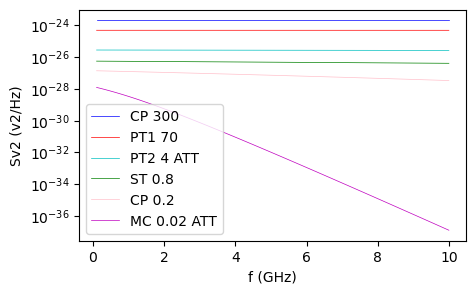

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

sv2_total=sum([fun_sv2(5,list_tem[i],i) for i in range(6)])
print (sv2_total)

list_db1=[db_rt,db_pt1,db_pt2,db_st,db_cp,db_mc+att1+att2+lpf]
def fun_sv2_change_db(f,tem,lay):
    f0=f*10**9 # GHz
    db=sum(list_db1[lay:6])
    # tem=tem[lay]
    r=50 # 阻抗先取定值
    sv2=4*r*hc*f0/(np.exp(hc*f0/kb/tem)-1)*10**(-db/10)
    return sv2
sv2_total1=sum([fun_sv2_change_db(5,list_tem[i],0) for i in range(6)])
print (sv2_total1)

fig=plt.figure(figsize=(5,3))
x=np.linspace(0.1,10,100)

ax=fig.add_subplot()
ax.set_yscale('log')
ax.set_xlabel('f (GHz)')
ax.set_ylabel('Sv2 (v2/Hz)')
ax.plot(x,fun_sv2_change_db(x,list_tem[0],0),'blue',lw=0.5,label="CP 300")
ax.plot(x,fun_sv2_change_db(x,list_tem[1],0),'red',lw=0.5,label="PT1 70")
ax.plot(x,fun_sv2_change_db(x,list_tem[2],0),'c',lw=0.5,label="PT2 4 ATT")
ax.plot(x,fun_sv2_change_db(x,list_tem[3],0),'green',lw=0.5,label="ST 0.8")
ax.plot(x,fun_sv2_change_db(x,list_tem[4],0),'pink',lw=0.5,label="CP 0.2")
ax.plot(x,fun_sv2_change_db(x,list_tem[5],0),'m',lw=0.5,label="MC 0.02 ATT")

ax.legend()
plt.show()


同样可以看到，当把所有的衰减器都放在 MC 层，对噪声的抑制效果最佳，能下降一个数量级，但是也需要考虑衰减器的热负荷与 MC 层的冷量。\
另外，无论是线缆的损耗，还是衰减器或者滤波器，最终都是将射频能量转化成热能散失，因此对于每层的热载功率，可以通过设置信号初始输入功率逐层计算。

下面附上功耗图

<img src="image/heatload-rf.png" width="60%">

对于 xy 各层的功耗如下。

LAYER | 输入功率dBm | 输出功率dBm | 单通道发热功率uw
----|----|----|----
RT-PT1 | -14.001 | -16.809 | 18.95184225
PT1-PT2 | -16.809 | -21.271 | 13.38694008
PT2-ST | -21.271 | -45.14 | 7.43214939
ST-CP | -45.14 | -47.73 | 0.0137541
CP-MC | -47.73 | -47.73 | 0
MC-QPU | -47.73 | -70 | 0.01676553

计算 READOUT-IN 通道和 XY 类似。关于 Z 的计算有时间再说。

上个cell的输入功率计算一下